# H5 Spike Detector for Scaled and Filtered Data

### This version assumes you have pre-processed the data in h5_explorer
- Reads in a h5 file of scaled and filtered experimental data from the Leaf Labs Willow System 
- Smooths the time series and detects spikes above threshold (set by median +/- range of probe noise)
- (Future) Clusters spikes according to their properties (width, peak, interspike interval)
- (Future) Outputs a csv with spike amplitude, width, interval for each channel for each category
- (future) output single and overlayed spike traces from each site according to probe geometry

## User Input

In [2]:
# Assumes this python notebook, the data file, and the imp. file are in same dir
datafile = 'experiment_C20200330-175336_filtered_64.h5'
fs = 30000
window = [0, 60] # in seconds. 4 mins is the max on an i7 8 core processor with 16GB RAM
chan_num = [0,64]
col_num = 3 # columns per shank
row_num = [22,20,22] # rows per column (# values should == # columns)

## Import Dependencies

In [3]:
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt
from IPython.display import HTML
from scipy.signal import butter, sosfiltfilt, sosfreqz
import time
import pandas as pd
import scipy 

## Read in the Multichannel Data
- for a 5 minute file it takes 10-30 mins
- keep checking for "dead kernel" errors
 - no dead kernel, it's still working
 
#### Experimental data

In [4]:
channels = list(range(chan_num[0],chan_num[1]))
f_data = h5py.File(datafile, 'r')
xs = f_data.get('sample_index') # channel # (x)
ys = f_data.get('channel_data')  # actual data in microvolts (y)
xs = xs[window[0]*fs:window[1]*fs]
ys = ys[window[0]*fs:window[1]*fs, channels] * 0.195 # Remove unconnected channels (based on impedence data)
display (HTML("<hr><h4>Data consists of " + str(ys.shape[1]) + 
              " columns of data (channels, x) and " + str(ys.shape[0]) + 
              " rows of data (measurements, y)." + "The recording is " +
              str(round(ys.shape[0]/(fs * 60),3)) + " mins long. <hr>"))

## Savitzky-Golay Smoothing (Better than stringent band-pass)

In [5]:
def sgolay2d ( z, window_size, order, derivative=None):
    """
    """
    # number of terms in the polynomial expression
    n_terms = ( order + 1 ) * ( order + 2)  / 2.0

    if  window_size % 2 == 0:
        raise ValueError('window_size must be odd')

    if window_size**2 < n_terms:
        raise ValueError('order is too high for the window size')

    half_size = window_size // 2

    # exponents of the polynomial. 
    # p(x,y) = a0 + a1*x + a2*y + a3*x^2 + a4*y^2 + a5*x*y + ... 
    # this line gives a list of two item tuple. Each tuple contains 
    # the exponents of the k-th term. First element of tuple is for x
    # second element for y.
    # Ex. exps = [(0,0), (1,0), (0,1), (2,0), (1,1), (0,2), ...]
    exps = [ (k-n, n) for k in range(order+1) for n in range(k+1) ]

    # coordinates of points
    ind = np.arange(-half_size, half_size+1, dtype=np.float64)
    dx = np.repeat( ind, window_size )
    dy = np.tile( ind, [window_size, 1]).reshape(window_size**2, )

    # build matrix of system of equation
    A = np.empty( (window_size**2, len(exps)) )
    for i, exp in enumerate( exps ):
        A[:,i] = (dx**exp[0]) * (dy**exp[1])

    # pad input array with appropriate values at the four borders
    new_shape = z.shape[0] + 2*half_size, z.shape[1] + 2*half_size
    Z = np.zeros( (new_shape) )
    # top band
    band = z[0, :]
    Z[:half_size, half_size:-half_size] =  band -  np.abs( np.flipud( z[1:half_size+1, :] ) - band )
    # bottom band
    band = z[-1, :]
    Z[-half_size:, half_size:-half_size] = band  + np.abs( np.flipud( z[-half_size-1:-1, :] )  -band )
    # left band
    band = np.tile( z[:,0].reshape(-1,1), [1,half_size])
    Z[half_size:-half_size, :half_size] = band - np.abs( np.fliplr( z[:, 1:half_size+1] ) - band )
    # right band
    band = np.tile( z[:,-1].reshape(-1,1), [1,half_size] )
    Z[half_size:-half_size, -half_size:] =  band + np.abs( np.fliplr( z[:, -half_size-1:-1] ) - band )
    # central band
    Z[half_size:-half_size, half_size:-half_size] = z

    # top left corner
    band = z[0,0]
    Z[:half_size,:half_size] = band - np.abs( np.flipud(np.fliplr(z[1:half_size+1,1:half_size+1]) ) - band )
    # bottom right corner
    band = z[-1,-1]
    Z[-half_size:,-half_size:] = band + np.abs( np.flipud(np.fliplr(z[-half_size-1:-1,-half_size-1:-1]) ) - band )

    # top right corner
    band = Z[half_size,-half_size:]
    Z[:half_size,-half_size:] = band - np.abs( np.flipud(Z[half_size+1:2*half_size+1,-half_size:]) - band )
    # bottom left corner
    band = Z[-half_size:,half_size].reshape(-1,1)
    Z[-half_size:,:half_size] = band - np.abs( np.fliplr(Z[-half_size:, half_size+1:2*half_size+1]) - band )

    # solve system and convolve
    if derivative == None:
        m = np.linalg.pinv(A)[0].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, m, mode='valid')
    elif derivative == 'col':
        c = np.linalg.pinv(A)[1].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -c, mode='valid')
    elif derivative == 'row':
        r = np.linalg.pinv(A)[2].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -r, mode='valid')
    elif derivative == 'both':
        c = np.linalg.pinv(A)[1].reshape((window_size, -1))
        r = np.linalg.pinv(A)[2].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -r, mode='valid'), scipy.signal.fftconvolve(Z, -c, mode='valid')
    
smoothed = sgolay2d( ys, window_size=41, order=4)


(1800000, 64)


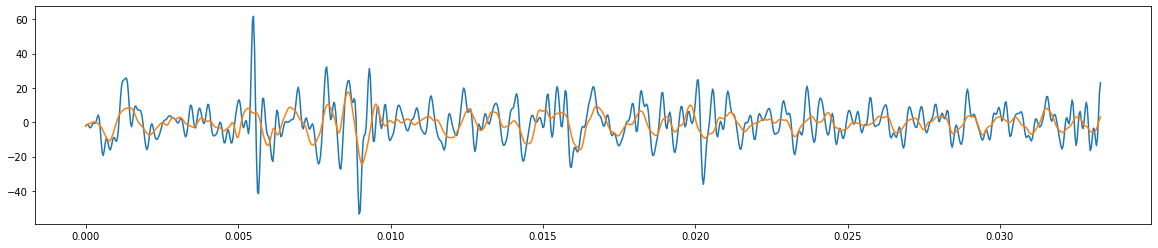

In [6]:
print(smoothed.shape)
start = 0
end = 1000
fig, ax = plt.subplots(figsize = (20,4))
ax.plot(xs[start:end]/fs,ys[start:end,4])
ax.plot(xs[start:end]/fs,smoothed[start:end,4])

## Search for events (based on Mean +/- SD of Smoothed signal)
- Search in 5s windows, get mean of smoothed data and sd
- from start to end of window find any peaks that are greater than 1 sd of baseline or compare MSE?
- save all data points from -3 to + 3 ms around peak and note the time of the peak
    - later look for overlap between epochs to determine wavelets vs single spikes 
    - i.e. granule cell activity from simple spikes

In [7]:
def event_search(raw, smooth, start, end, channels, thresh): 
    start = int(start * fs)
    end = int(end*fs)
    mn = fs-150 # minimum length of analysis window (0.995 s)
    peaks_x = {} # dict to catch peak times 
    peaks_y = {} # dict to catch peak amps
    peaks_b = {} # dict to catch peak baseline amps
    events_x = {} # dict to catch event trace x (3 ms before and after peak)
    events_y = {} # dict to catch event trace y (3 ms before and after peak)
    events_b = {} # dict to catch event trace baseline (3 ms before and after peak)
    print('Analyzing channel: ', end = ' ')
    for j in channels:
        print(j, end = ' ')
        i = start
        epoch = 0
        peak_x = []
        peak_y = []
        peak_b = []
        rep = 0
        while i < end-11: # search all the rows 
            if i % mn == 0 and i < end - mn: # moving window every 10ms
                savg = np.median(abs(smooth[i:i+mn,j]))
                ssd = np.std(smooth[i:i+mn,j])*thresh
            if raw[i,j] > savg  and raw[i,j] > max(raw[i+1:i+10,j]) and raw[i,j] > raw[i-1,j] and i-10 >= 0:
                peak_x.append(i)
                peak_y.append(raw[i,j])
                peak_b.append(savg)
                events_x['xCh'+str(j)+'_'+str(rep)] = list(range(i-10,i+10))
                events_y['yCh'+str(j)+'_'+str(rep)] = raw[i-10:i+10,j]
                rep = rep + 1
            i = i + 1
        peaks_x[str(j)] = peak_x
        peaks_y[str(j)] = peak_y
        peaks_b[str(j)] = peak_b
    peaks = [peaks_x,peaks_y,peaks_b]
    events = [events_x, events_y]
    return peaks, events
            

start = 0 # seconds
end = 1 # seonds
# started at 11:40 PM, 2 mins for 30s on 1 channel on a macbook air with 8GB RAM
# at channel 32 at 11:52 PM 

# for all channels, 30s trace started at 1:39 PM. ch 16 at 1:47

channels = list(range(chan_num[0],chan_num[1]))
# Thresh is a multiplier of the std of the smoothed mean for every 10ms with 10% overlap
peaks, events = event_search (raw = ys, smooth = smoothed, start = start, end = end, 
                              channels = channels,thresh = 1)            


Analyzing channel:  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 

- Cerebellar recordings, all spikes kept
- Will sort them and see if they cluster into granule cell activity, complex spikes, simple spikes

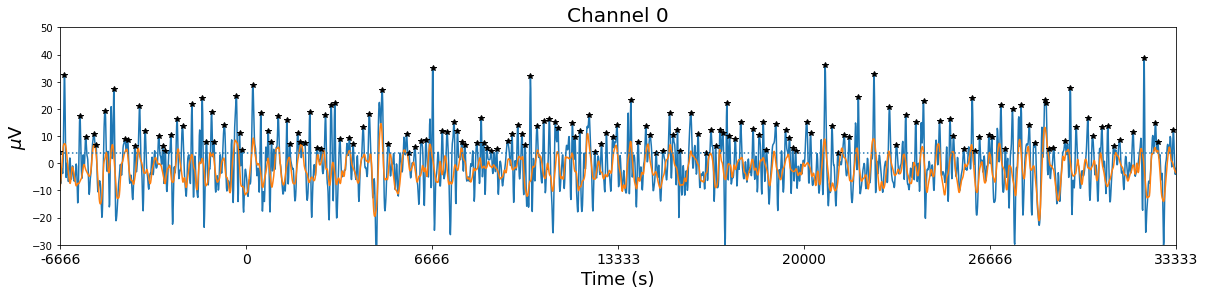

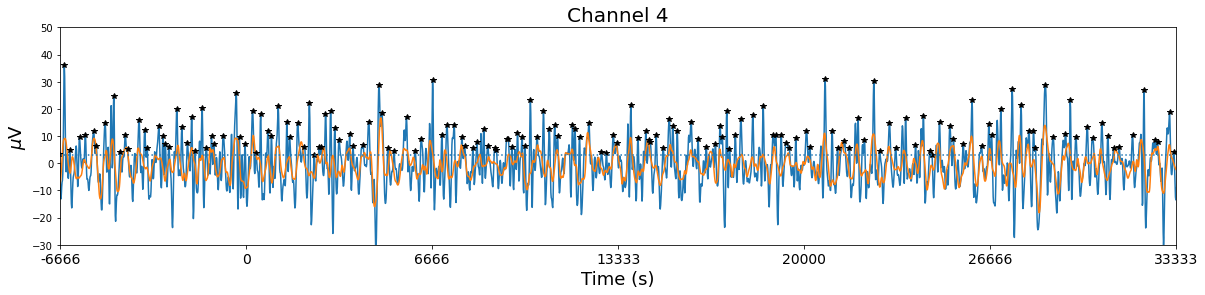

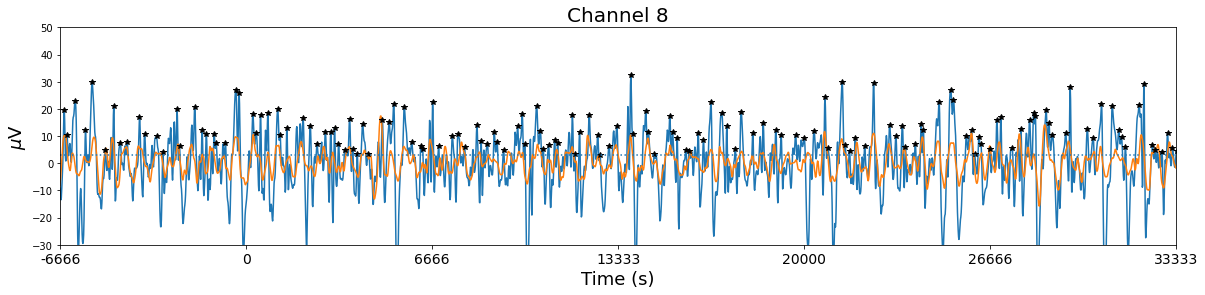

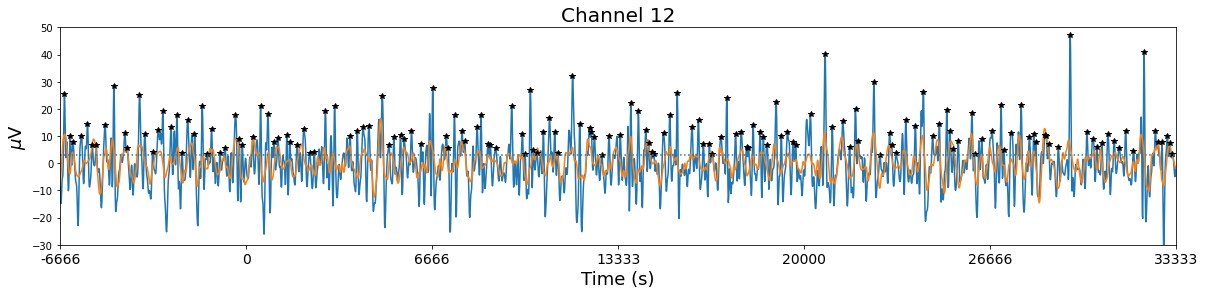

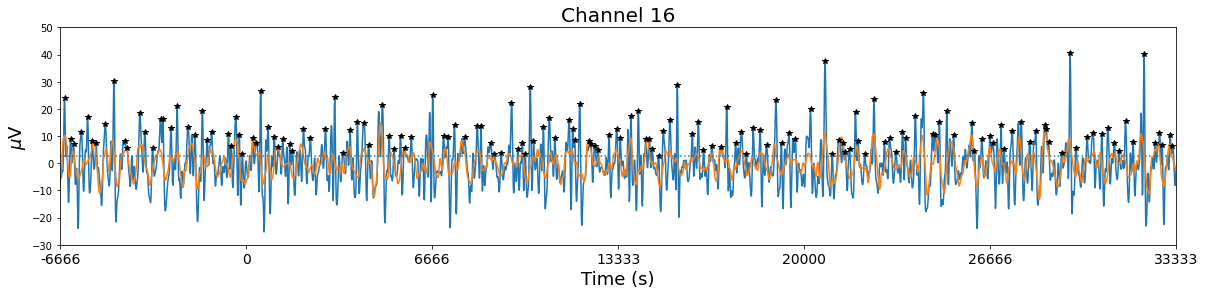

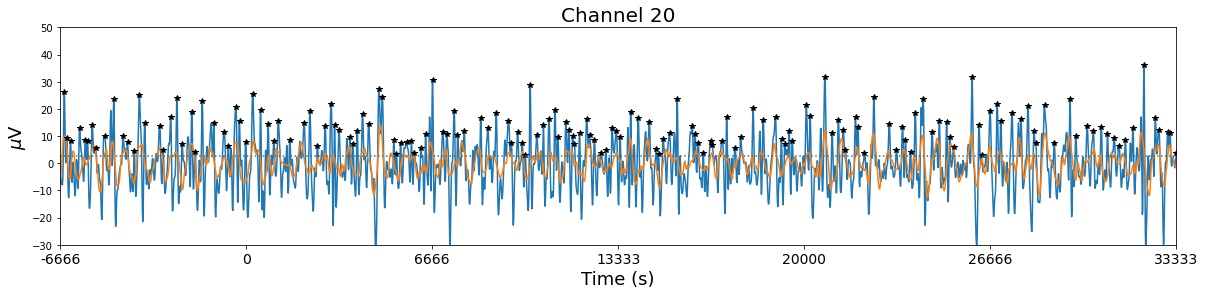

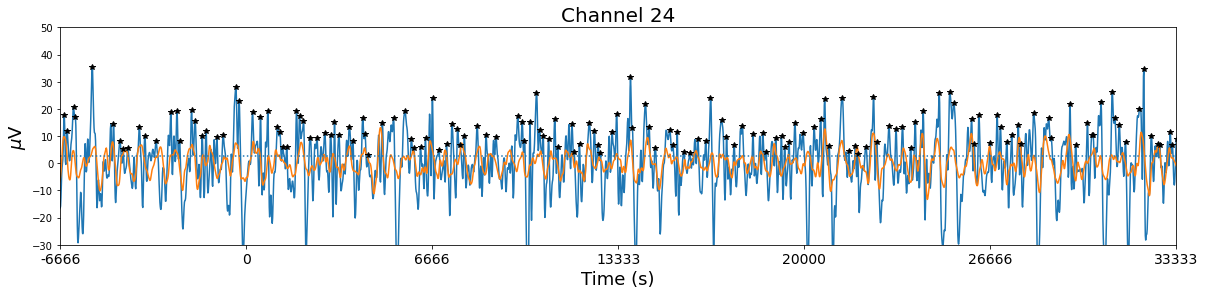

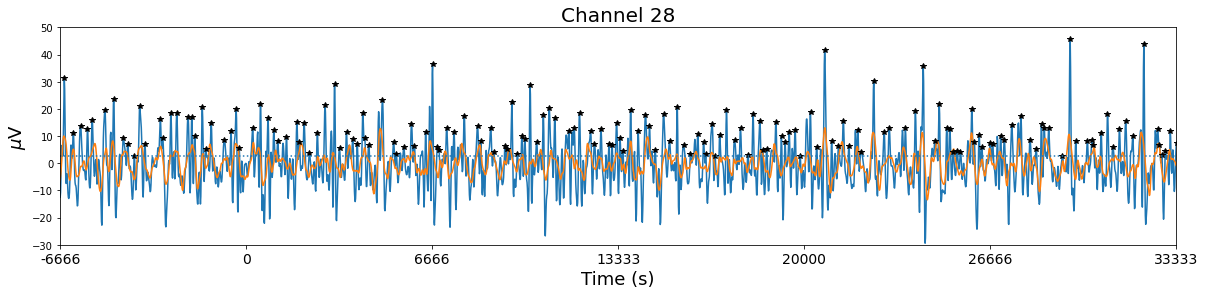

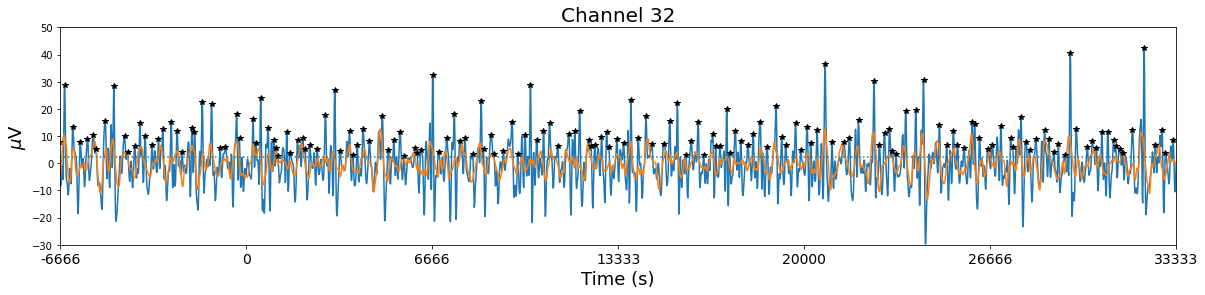

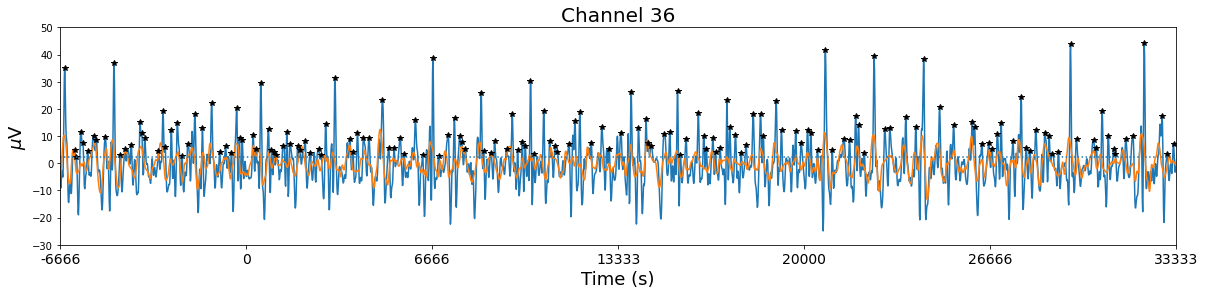

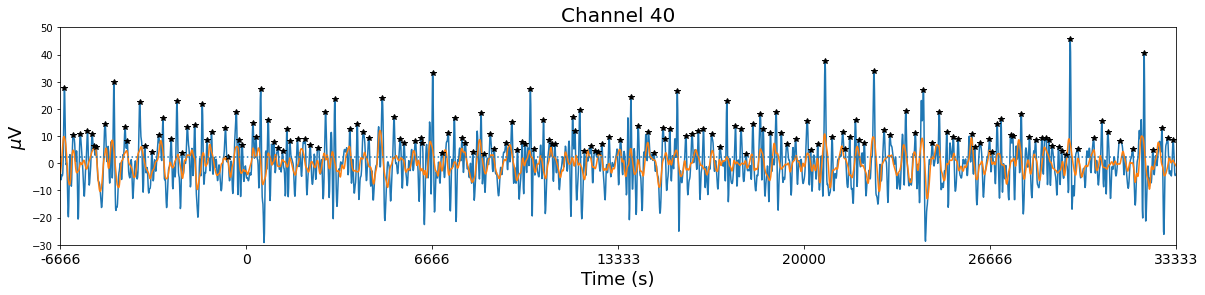

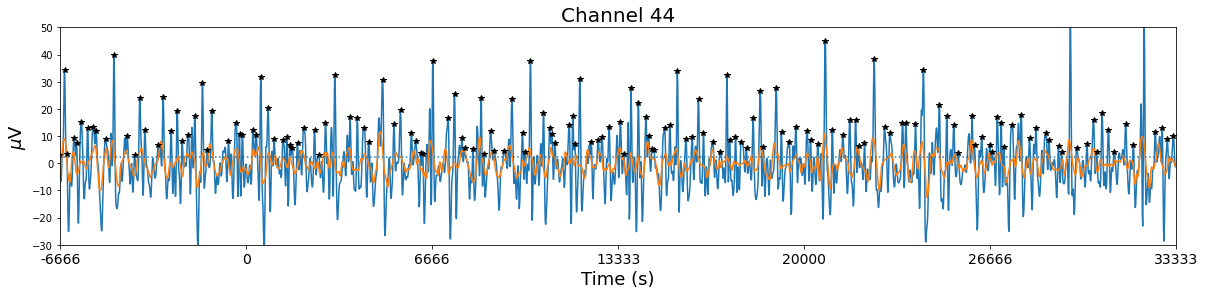

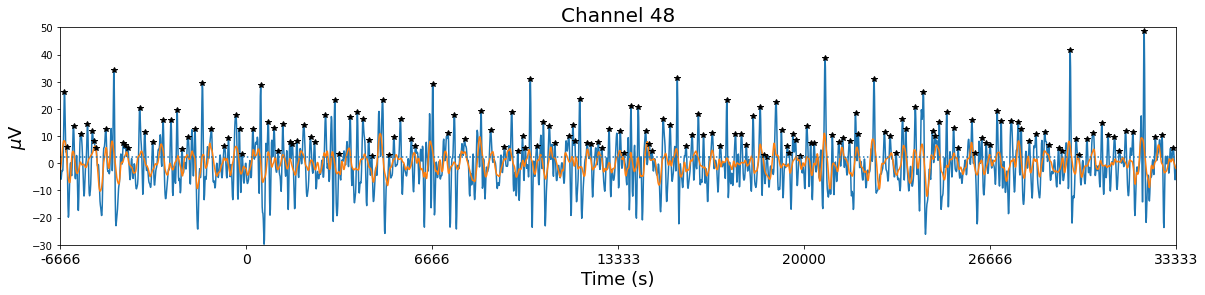

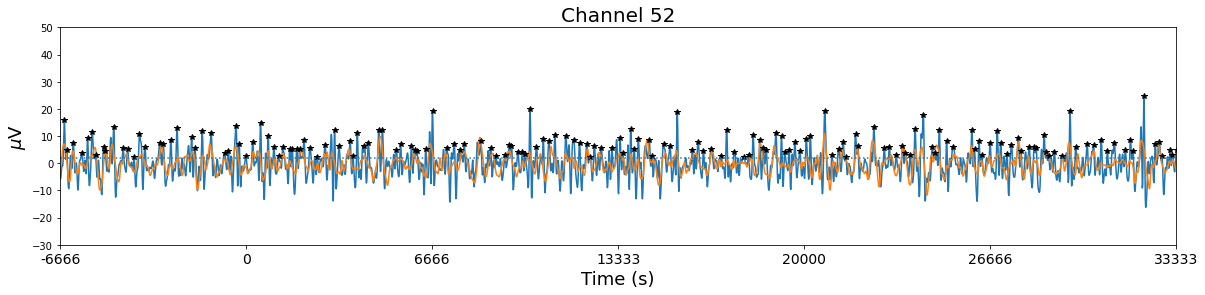

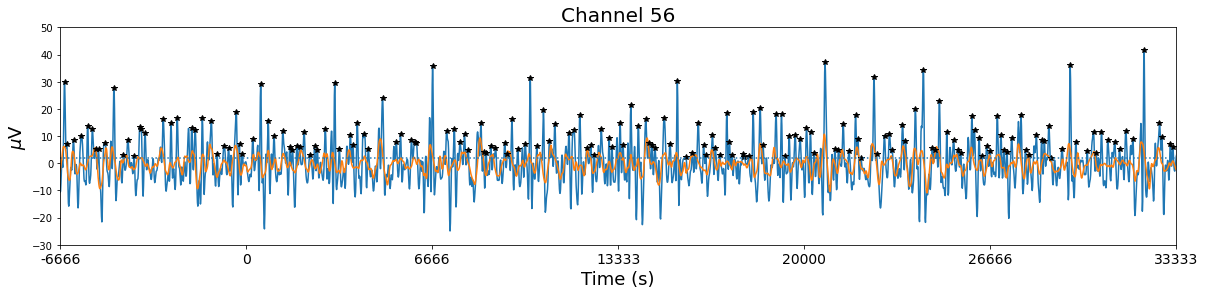

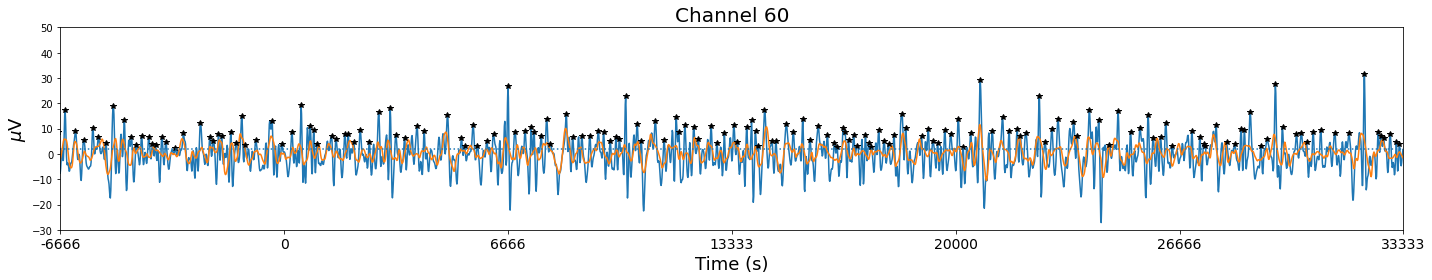

In [8]:
start = int(0 * fs)
end = int(29.5* fs)
chans = list(range(chan_num[0],chan_num[1],4))
for chan in channels:
    fig, ax = plt.subplots(figsize = (20,4))
    ax.plot(xs[start:end],ys[start:end,chan])
    ax.plot(xs[start:end],smoothed[start:end,chan])
    ax.plot(peaks[0][str(chan)],
        peaks[1][str(chan)], 
        ls = 'none', marker = '*', markersize = 6, color = 'black')
    ax.axhline (peaks[2][str(chan)][50], ls = ':')
    ax.set_title("Channel " + str(chan), fontsize = 20)
    xticks = ax.get_xticks()
    xticks = [int(t/30) for t in xticks]
    ax.set_xticklabels (xticks, fontsize = 14)
    ax.set_ylabel(r'$\mu$V', fontsize = 18)
    ax.set_xlabel('Time (s)', fontsize = 18)
    ax.set_xlim(0.2 *fs,.3*fs)
    ax.set_ylim(-30,50)
plt.tight_layout()

To Do:
- output to csv or h5
- add 1st pass filter (450 Hz - 5000Hz) and scaling to eliminate pre-processing steps
- Make analysis script with clustering (Kmeans first, then PCA if not good enough)
- Make neighborhood analysis script

## Convert Peaks and Events Dictionaries to Dataframes for easy file handling
- will contain NaN values as padding
- might take a few minutes on a slower computer

In [9]:
def get_index_from_dict(dct):
    """Finds the max length of rows for all keys in a dict"""
    max_len = 0
    for keys,values in dct.items():
        for key in keys:
            tmp = len(values)
            if tmp > max_len:
                max_len = tmp
    max_index = list(range(0,max_len))
    return max_index,max_len

def make_df_peak (dct, channels, prefix):
    """Makes a dataframe out of a dict with uneven row numbers per column"""
    ind,ind_len = get_index_from_dict(dct)
    df = pd.DataFrame(index = ind)
    for chan in channels:
        col = str(chan)
        col_len = len(dct[col])
        if col_len <= ind_len:
            dct[col].extend(np.nan for t in range(col_len,ind_len)) # Fill in missing values with NaN
            df[prefix +'Ch'+ col] = dct[col] 
    return df

channels = list(range(chan_num[0],chan_num[1]))
df_peaks_x = make_df_peak(peaks[0],channels, 'x')
df_peaks_y = make_df_peak(peaks[1],channels, 'y')
df_peaks_b = make_df_peak(peaks[2],channels, 'b')
df_peaks = df_peaks_x.join([df_peaks_y, df_peaks_b])
idx,id_len = get_index_from_dict(events[0])
df_events_x = pd.DataFrame(events[0], columns = events[0].keys(), index = idx)
df_events_y = pd.DataFrame(events[1], columns = events[1].keys(), index = idx)
df_events = df_events_x.join(df_events_y)

## Save the events and peaks to csv files
- These may get too big to open in excel
- If so, break them down into 64 channels each with 2 min recordings

In [10]:
df_peaks.to_csv(datafile.replace('.h5','_peaks.csv'))
df_events.to_csv(datafile.replace('.h5', '_events.csv'))

In [11]:
print(df_peaks.columns)

Index(['xCh0', 'xCh4', 'xCh8', 'xCh12', 'xCh16', 'xCh20', 'xCh24', 'xCh28',
       'xCh32', 'xCh36', 'xCh40', 'xCh44', 'xCh48', 'xCh52', 'xCh56', 'xCh60',
       'yCh0', 'yCh4', 'yCh8', 'yCh12', 'yCh16', 'yCh20', 'yCh24', 'yCh28',
       'yCh32', 'yCh36', 'yCh40', 'yCh44', 'yCh48', 'yCh52', 'yCh56', 'yCh60',
       'bCh0', 'bCh4', 'bCh8', 'bCh12', 'bCh16', 'bCh20', 'bCh24', 'bCh28',
       'bCh32', 'bCh36', 'bCh40', 'bCh44', 'bCh48', 'bCh52', 'bCh56', 'bCh60'],
      dtype='object')
